In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Force network to output values in double format
tf.keras.backend.set_floatx('float64')

### Define the network

In [7]:
# Define the number of sigmoid activations in the hidden layer
H = 10

model1 = keras.Sequential([
    # 1 input -> 10 hidden sigmoids -> 1 linear output
    layers.Dense(units = H, activation = 'sigmoid', input_shape = (1,)),
    layers.Dense(units = H, activation = 'sigmoid',),
    layers.Dense(units = H, activation = 'sigmoid',),
    layers.Dense(units = H, activation = 'sigmoid',),
    layers.Dense(units = H, activation = 'sigmoid',),
    layers.Dense(units = 1, activation = 'linear', use_bias = False)
])
# Show the model; the output layer has no bias, therefore, 10 weights only
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                20        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 10)                110       
                                                                 
 dense_18 (Dense)            (None, 10)                110       
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
 dense_20 (Dense)            (None, 1)                 10        
                                                                 
Total params: 470
Trainable params: 470
Non-trainable 

### Define grid points to use as input data

In [3]:
# Endpoints a and b
# N + 2 = 10 grid points in total (including a and b)
a = 0
b = 1
N = 8
h = (b - a)/(N + 1)

# x holds the grid points to be used as input data
x = []
for i in range(N + 2):
    x.append(a + i*h)
    
# Remake the input data as a numpy array with shape = (10,1)
input_data = np.array(x)
input_data = input_data.reshape(10,1)
input_data

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

### Training routine

In [87]:
def trainStep(x,opt):
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            
            # Compute the model output
            N = model1([x])
        
        # Compute dN/dx
        Nx = tape1.gradient(N, x)
        
        # Plug trial solution into ODE:
        eqn = (x*Nx + N + (x+(1+3*x**2)/(1+x+x**3))*(1+x*N)-
               x**3-2*x-x**2*(1+3*x**2)/(1+x+x**3))
        
        # The loss is the sum of squares of the residual error over the batch points
        loss = tf.reduce_sum(tf.square(eqn))
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model1.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model1.trainable_variables))
    
    return loss

In [88]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam(lr)
    
    # Define an empty numpy array to hold the loss at each epoch
    epoch_loss = np.zeros(epochs)
    
    # Data preprocessing
    batch_size = 5
    input_data = np.column_stack([x]).astype(np.float64)
    
    # Splits the data into batches of size batch_size
    data_sample = tf.data.Dataset.from_tensor_slices(input_data)
    data_sample = data_sample.cache().shuffle(10).batch(batch_size)
    
    # ds is made to hold the batches and prefetch minimizes the step time
    ds = tf.data.Dataset.zip((data_sample))
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Main training loop
    for i in range(epochs):
        
        # Iterate over the batches in ds
        for j in ds:
            
            # Compute the loss at the given batch and add to the total loss in the epoch
            PDEloss = trainStep(j,opt)
            epoch_loss[i] += PDEloss
        
        # Print the loss at each epoch
        if np.mod(i, 100)==0 or i == 9999:
          print("PDE loss in {}th epoch: {: 1.4e}.".format(i, epoch_loss[i]))
    
    return epoch_loss

In [89]:
epochs = 10000
loss = PINNtrain(input_data,epochs)

PDE loss in 0th epoch:  3.2237e+00.
PDE loss in 100th epoch:  5.0737e-02.
PDE loss in 200th epoch:  2.0394e-02.
PDE loss in 300th epoch:  1.3928e-02.
PDE loss in 400th epoch:  6.8364e-03.
PDE loss in 500th epoch:  7.4538e-02.
PDE loss in 600th epoch:  7.3502e-03.
PDE loss in 700th epoch:  8.3849e-03.
PDE loss in 800th epoch:  5.4669e-03.
PDE loss in 900th epoch:  4.8576e-03.
PDE loss in 1000th epoch:  7.9862e-03.
PDE loss in 1100th epoch:  7.6321e-02.
PDE loss in 1200th epoch:  3.7208e-03.
PDE loss in 1300th epoch:  4.3125e-02.
PDE loss in 1400th epoch:  8.9405e-03.
PDE loss in 1500th epoch:  4.5770e-03.
PDE loss in 1600th epoch:  4.0588e-03.
PDE loss in 1700th epoch:  2.0550e-03.
PDE loss in 1800th epoch:  2.4251e-03.
PDE loss in 1900th epoch:  5.2564e-03.
PDE loss in 2000th epoch:  1.9283e-03.
PDE loss in 2100th epoch:  2.3373e-03.
PDE loss in 2200th epoch:  2.3046e-03.
PDE loss in 2300th epoch:  9.4340e-03.
PDE loss in 2400th epoch:  2.0107e-03.
PDE loss in 2500th epoch:  1.6978e-03

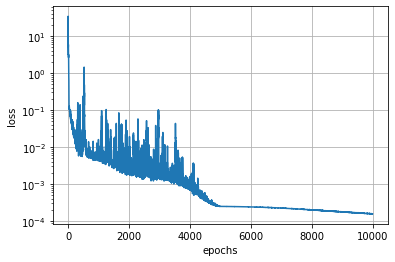

In [90]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid()
plt.show()

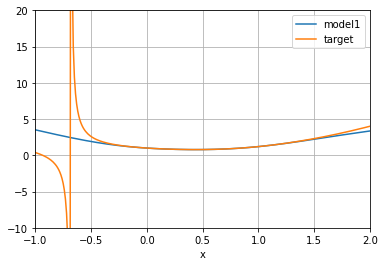

In [97]:
x = np.linspace(-1,2,300)
target = []

for i in range(300): 
    target.append((np.exp(-x[i]**2/2))/(1+x[i]+x[i]**3) + x[i]**2)
     
plt.plot(x,1 + x*model1([x]).numpy().T[0], label = 'model1')
plt.plot(x,target, label = 'target')
plt.xlabel('x')
plt.axis([-1,2,-10,20])
plt.legend(loc =  'upper right')
plt.grid()
plt.show()

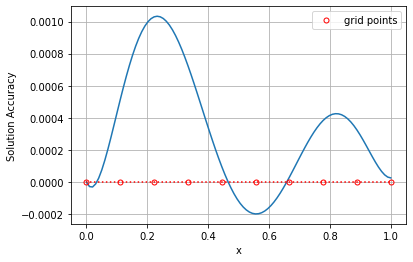

In [93]:
grid_points = np.linspace(0,1,10)
x = np.linspace(0,1,100)
target = []

for i in range(100): 
    target.append((np.exp(-x[i]**2/2))/(1+x[i]+x[i]**3) + x[i]**2)

plt.plot(x,target-(1 + x*model1([x]).numpy().T[0]))
plt.plot(x,[0]*100, ':r')
plt.plot(grid_points,[0]*10, 'o', color = 'red', mfc = 'none', markersize = 5, label = 'grid points')
plt.ylabel('Solution Accuracy')
plt.xlabel('x')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()